# Demonstrating how to access AWS telemetry data stored in DyanmoDB     

## Data Ingestion

### Get from AWS

In [302]:
import boto3
from boto3.dynamodb.conditions import Key

dyanmodb = boto3.resource('dynamodb', region_name="us-east-2")
telemetry_table = dyanmodb.Table('telemetry')

In [303]:
import pandas as pd

telemetry_data = telemetry_table.query(
    KeyConditionExpression=Key('test_id').eq('dev-pi2')
)['Items']

pd.DataFrame.from_dict(telemetry_data)

,clockState,lastDeadman,throttleTooHigh,throttle,current,motorInitializing,timestamp,speed,rpm,test_id,voltage
0,0,00.00.00\n,0,0,1611,0,2023-05-26 21:22:52.876,0,0,jmts-current-comparison,2435
1,0,00.00.00\n,0,0,1612,0,2023-05-26 21:22:52.976,0,0,jmts-current-comparison,2436
2,0,00.00.00\n,0,0,1691,0,2023-05-26 21:22:53.075,0,0,jmts-current-comparison,2438
3,0,00.00.00\n,0,0,1628,0,2023-05-26 21:22:53.175,0,0,jmts-current-comparison,2439
4,0,00.00.00\n,0,0,1622,0,2023-05-26 21:22:53.275,0,0,jmts-current-comparison,2436
...,...,...,...,...,...,...,...,...,...,...,...
563,0,00.00.00\n,0,0,1627,0,2023-05-26 21:27:14.472,0,0,jmts-current-comparison,2434
564,0,00.00.00\n,0,0,1655,0,2023-05-26 21:27:14.475,0,0,jmts-current-comparison,2439
565,0,00.00.00\n,0,0,1610,0,2023-05-26 21:27:18.529,0,0,jmts-current-comparison,2434
566,0,00.00.00\n,0,0,1643,0,2023-05-26 21:27:18.534,0,0,jmts-current-comparison,2434


### Processing Data

In [304]:
from typing import List
from Telemetry import TelemetryProcessor, TelemetryDataPoint, InstantEfficiencyDataPoint
from datetime import datetime, timedelta

def codeToVoltage(x):
    return 0.02048 * x + -0.53823

def codeToAmps(x):
    return 0.01082 * x + -20.17682

processed: List[TelemetryDataPoint] = []

for point in telemetry_data:
    processed.append(
        TelemetryDataPoint(
            timestamp=datetime.strptime(point['timestamp'], '%Y-%m-%d %H:%M:%S.%f') - timedelta(hours= 4),
            speed=float(point['speed']) / 1000, # m/h -> km/h
            voltage=codeToVoltage(int(point['voltage'])),
            current=codeToAmps(int(point['current'])),
            rpm=int(point['rpm']) * -1
        )
    )

currentCodes = [int(p['current']) for p in telemetry_data]
voltageCodes = [int(p['voltage']) for p in telemetry_data]

instantEfficiencyDataPoints = TelemetryProcessor.get_inst_efficiency(processed, 10)

## Graphing Data

### RPM, Speed and Current over time

/var/folders/tw/qm7nc9kd0j91hj74kmf3hk0r0000gn/T/ipykernel_81605/1346676097.py:29: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


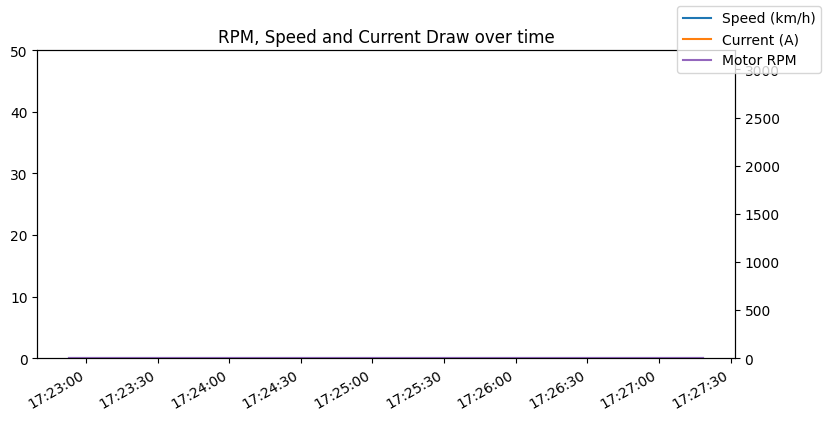

In [305]:
import matplotlib.pyplot as plt
timestamps = [point.timestamp for point in processed]
speeds = [point.speed / 1000 for point in processed]
currents = [point.current for point in processed]
voltages = [point.voltage for point in processed]
rpms = [abs(point.rpm) for point in processed]
joules = [point.current * point.voltage for point in processed]

fig, leftAx = plt.subplots()
fig.set_size_inches(9,4)
leftAx.set_title("RPM, Speed and Current Draw over time")
leftAx.set_ylim(0, 50)

rightAx = leftAx.twinx()
rightAx.set_ylim(0, 3200)

rpmLine = rightAx.plot(timestamps, rpms, color='tab:purple', label='Motor RPM')
speedLine = leftAx.plot(timestamps, speeds, label='Speed (km/h)')
currentLine = leftAx.plot(timestamps, currents, color='tab:orange', label='Current (A)')

fig.legend(loc='upper right')

for label in leftAx.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')

leftAx.grid(False)
rightAx.grid(False)

fig.show()

### Instant Efficiency over Time

[InstantEfficiencyDataPoint(timestamp=datetime.datetime(2023, 5, 26, 17, 22, 53, 375000), instant_efficiency=0.0), InstantEfficiencyDataPoint(timestamp=datetime.datetime(2023, 5, 26, 17, 22, 55, 794000), instant_efficiency=-0.0), InstantEfficiencyDataPoint(timestamp=datetime.datetime(2023, 5, 26, 17, 22, 56, 827000), instant_efficiency=0.0), InstantEfficiencyDataPoint(timestamp=datetime.datetime(2023, 5, 26, 17, 23, 1, 862000), instant_efficiency=-0.0), InstantEfficiencyDataPoint(timestamp=datetime.datetime(2023, 5, 26, 17, 23, 2, 982000), instant_efficiency=-0.0), InstantEfficiencyDataPoint(timestamp=datetime.datetime(2023, 5, 26, 17, 23, 4, 13000), instant_efficiency=-0.0), InstantEfficiencyDataPoint(timestamp=datetime.datetime(2023, 5, 26, 17, 23, 5, 49000), instant_efficiency=0.0), InstantEfficiencyDataPoint(timestamp=datetime.datetime(2023, 5, 26, 17, 23, 8, 655000), instant_efficiency=-0.0), InstantEfficiencyDataPoint(timestamp=datetime.datetime(2023, 5, 26, 17, 23, 9, 725000), i

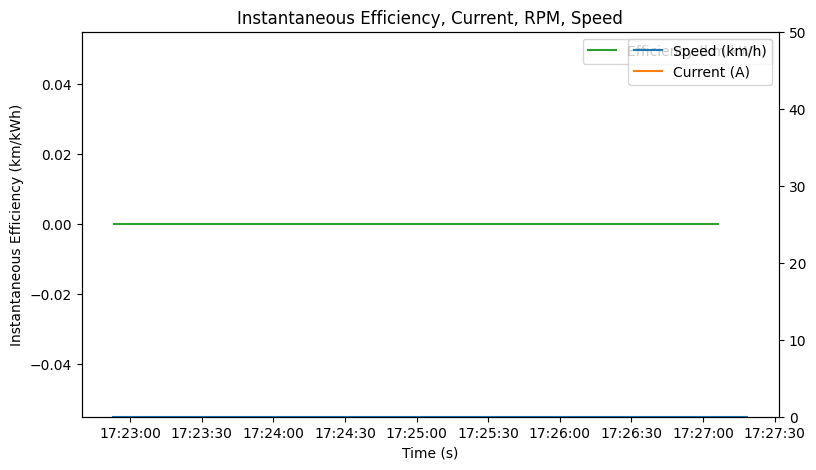

In [306]:
import matplotlib.pyplot as plt
from datetime import datetime

timestamps = [point.timestamp for point in processed]
speeds = [point.speed / 1000 for point in processed]
currents = [point.current for point in processed]
rpms = [abs(point.rpm) for point in processed]
joules = [point.current * point.voltage for point in processed]

fig, leftAx = plt.subplots()
rightAx = leftAx.twinx()
fig.set_size_inches(9,5)

rightAx.plot(timestamps, speeds, "-", label="Speed (km/h)")
rightAx.plot(timestamps, currents, "-", label="Current (A)")

leftAx.set_title("Instantaneous Efficiency, Current, RPM, Speed")
leftAx.set_xlabel("Time (s)")
leftAx.set_ylabel("Instantaneous Efficiency (km/kWh)")

rightAx.set_ylim(0, 50)


print(instantEfficiencyDataPoints)
leftAx.plot(
    [point.timestamp for point in instantEfficiencyDataPoints],
    [point.instant_efficiency for point in instantEfficiencyDataPoints],
    label="Efficiency (km/kWh)",
    color='tab:green'
)

leftAx.legend()
rightAx.legend()

### Battery voltage over time

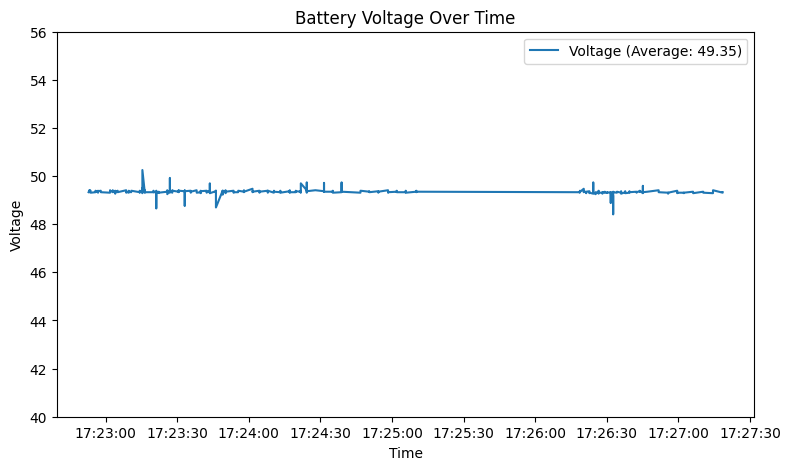

In [307]:
fig, ax = plt.subplots()
fig.set_size_inches(9,5)

ax.set_ylim(40, 56)

ax.set_title("Battery Voltage Over Time")
ax.set_ylabel("Voltage")
ax.set_xlabel("Time")

ax.plot(timestamps, voltages, label="Voltage")
legend = ['Voltage (Average: %.2f)' %(sum(voltages) / len(voltages))]
ax.legend(legend)

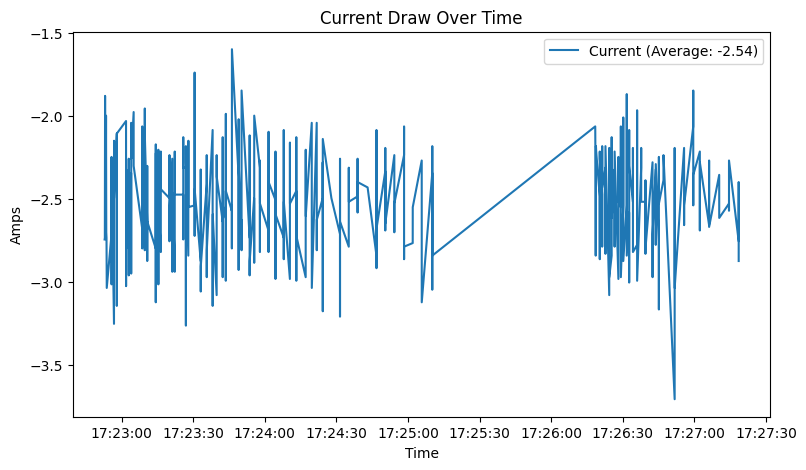

In [308]:
fig, ax = plt.subplots()
fig.set_size_inches(9,5)

ax.set_title("Current Draw Over Time")
ax.set_ylabel("Amps")
ax.set_xlabel("Time")

ax.plot(timestamps, currents)
legend = ['Current (Average: %.2f)' %(sum(currents) / len(currents))]
ax.legend(legend)